## Exercise 1

In this exercise, you will use PCA to reduce the MINST data set and visualize the approximation.

### Step 1: Load the data

You don't actually have to do anything here!  Just run the code...

In [1]:
# @SHOW
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load MNIST data
mnist = fetch_openml("mnist_784", version=1)
X, y = mnist["data"].values, mnist["target"].astype(int).values

# Sample the dataset to speed up computation (Optional)
X, y = X[:7000], y[:7000]

# Split the dataset
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Step 2: Use PCA to reduce the data set


Visualize your result with a 2d scatter plot, colored by class (the digit identitiy)

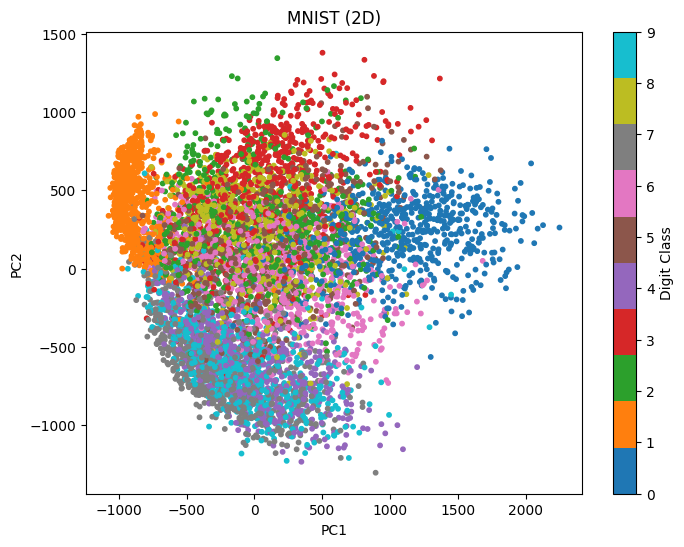

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# PCA to get to 2D
pca = PCA(n_components=2)
X_mnist_pca = pca.fit_transform(X)

# Scatter plot colored by digit class
plt.figure(figsize=(8, 6))
plt.scatter(X_mnist_pca[:, 0], X_mnist_pca[:, 1], c=y,cmap="tab10", s=10)
plt.title("MNIST (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Digit Class")
plt.show()



#### Step 3: Scree plot

Calculate and visualize a scree plot for the first 40 component.  The y-axis should be 'percent of variance explained'.

Text(0.5, 1.0, 'Scree Plot')

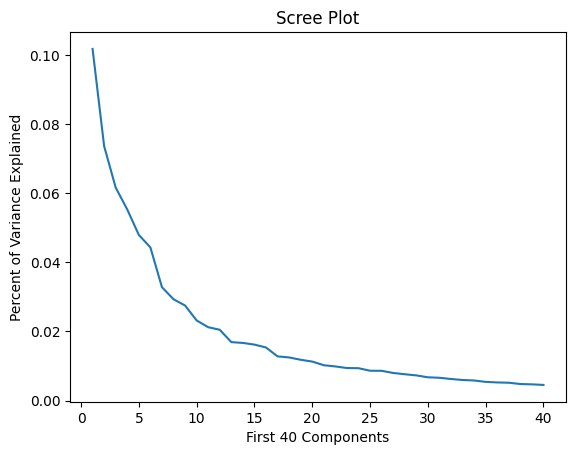

In [14]:
pca = PCA(n_components = 40)
X_pca = pca.fit_transform(X)

plt.figure()
plt.plot(range(1,41), pca.explained_variance_ratio_)
plt.ylabel("Percent of Variance Explained")
plt.xlabel("First 40 Components")
plt.title("Scree Plot")

#### Step 4: Select the number of components


Calculate the number of components required to explain 95% of the variance

In [16]:
pca_95 = PCA(n_components = 0.95)
pca_95.fit(X)

print(f"Components needed for 95% of variance to be explained: {pca_95.n_components_}")


Components needed for 95% of variance to be explained: 149


### Step 5: Visualize a digit in the reduced dimensionality space


I've provided a function for visualizing a digit. Figure out how to visualize the same digit using the number of dimensions identified in Step 4.

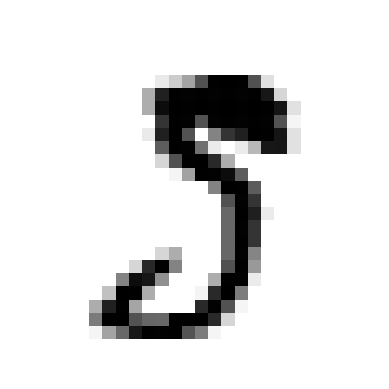

In [17]:
# @SHOW
def plot_mnist_digit(digit):
    """Plot a single MNIST digit.

    Parameters:
    digit (numpy array): A flattened 1D numpy array of length 784.

    """
    # Reshape the flattened digit to 28x28 image
    digit_image = digit.reshape(28, 28)
    
    plt.imshow(digit_image, cmap='binary')
    plt.axis("off")
    plt.show()

plot_mnist_digit(X_mnist_train[0])

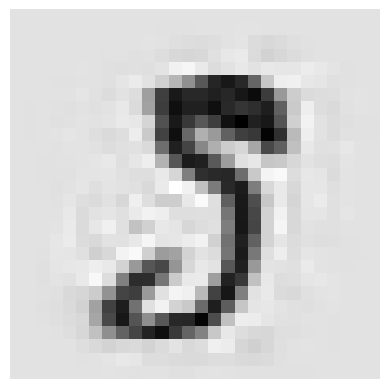

In [21]:
pca_149 = PCA(n_components = 149)
pca_149.fit_transform(X_mnist_train)

X_train = pca_149.transform(X_mnist_train)
X_reduced = X_train[0]
X_reconstructed = pca_149.inverse_transform(X_reduced)

plot_mnist_digit(X_reconstructed)



### Step 6: Use dimensionality reduction to preprocess data


See how a KNN Classifier works with and without dimensionality reduction. Preserve 80% of the variance.

In [23]:
#KNN without reduction
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_mnist_train, y_mnist_train)

y_pred_knn = knn.predict(X_mnist_test)
acc_knn = accuracy_score(y_mnist_test, y_pred_knn)

#PCA with 80% var
pca_80 = PCA(n_components = 0.8)
X_train_pca = pca_80.fit_transform(X_mnist_train)
X_test_pca = pca_80.transform(X_mnist_test)

#KNN with pca
knn_pca = KNeighborsClassifier(n_neighbors = 10)
knn_pca.fit(X_train_pca, y_mnist_train)

y_pred_pca = knn_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_mnist_test, y_pred_pca)

#results
print(f"KNN accuracy without reduction: {acc_knn}")
print(f"KNN accuracy with reduction: {acc_pca}")



KNN accuracy without reduction: 0.9307142857142857
KNN accuracy with reduction: 0.9478571428571428


## Exercise 2
<!-- @q -->
1. Try using t-SNE to visualize the MNIST data above.

Text(0, 0.5, 't-SNE 2')

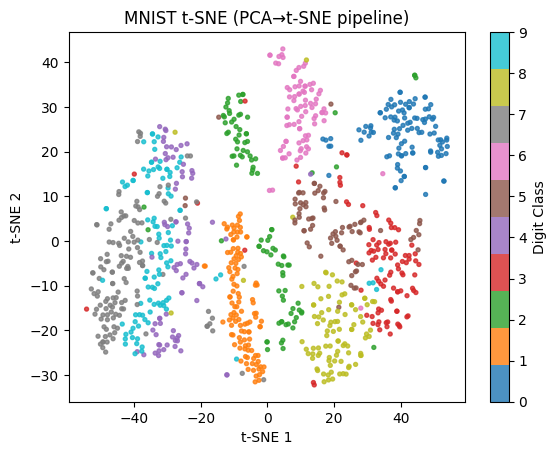

In [29]:
from sklearn.manifold import TSNE

#Subsample prep for TNSE
rng = np.random.RandomState(42)
idx = rng.choice(len(X), size = 1000)
X_sub = X[idx]
y_sub = y[idx]

#Reduction to 50 before TSNE
pca = PCA(n_components = 50, random_state = 42)
X_50 = pca.fit_transform(X_sub)

#TSNE
tsne = TSNE(
    n_components = 2,
    init = "pca",
    max_iter = 1000,
    random_state = 42
)
X_tsne = tsne.fit_transform(X_50)

#Plot 
plt.figure()
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, cmap="tab10", s=8, alpha=0.8)
cbar = plt.colorbar(sc)
cbar.set_label("Digit Class")
plt.title("MNIST t-SNE (PCA→t-SNE pipeline)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")


2. Try using a KNN classifier to predict the data with TSNE.  How does it perform?

In [32]:
pca = PCA(n_components = 50, random_state = 42)
X_train50 = pca.fit_transform(X_mnist_train)
X_test50 = pca.transform(X_mnist_test)

#combine the data back to allow TNSE
X_combined = np.vstack([X_train50, X_test50])

#TSNE
tsne = TSNE(
    n_components = 2,
    init = "pca",
    max_iter = 1000,
    random_state = 42
)
X_tsne1 = tsne.fit_transform(X_combined)

#split again for KNN
n_train = X_mnist_train.shape[0]
X_train2 = X_tsne1[:n_train]
X_test2 = X_tsne1[n_train:]

#KNN
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train2, y_mnist_train)
y_pred = knn.predict(X_test2)

print(f"KNN accuracy score on TSNE: {accuracy_score(y_mnist_test, y_pred)}")

#Note this suffers from data leakage because you cant fit TSNE on test and train data
#rather it is on the entire data


KNN accuracy score on TSNE: 0.935


## Exercise 3

Try using UMAP to process the MNIST data.  Visualize the data first.

In [ ]:
# @SHOW
# You might need to install UMAP.  If so, uncomment the following lines and run them

# %pip install numpy==2.0
# %pip install umap-learn

In [ ]:
# Your code here


Now, calculate accuracy with KNN.

In [ ]:
# Your code here


## Exercise 4

In the following, I've set up some sample data. Examine the relative performance of PCA and UMAP; for each, try gradually increasing the number of dimensions and examine the impact on KNN. You should also try different parameter settings for UMAP. Make sure to visualize your data after dimensionality reduction to understand what's going on!

Original Data Accuracy: 0.844


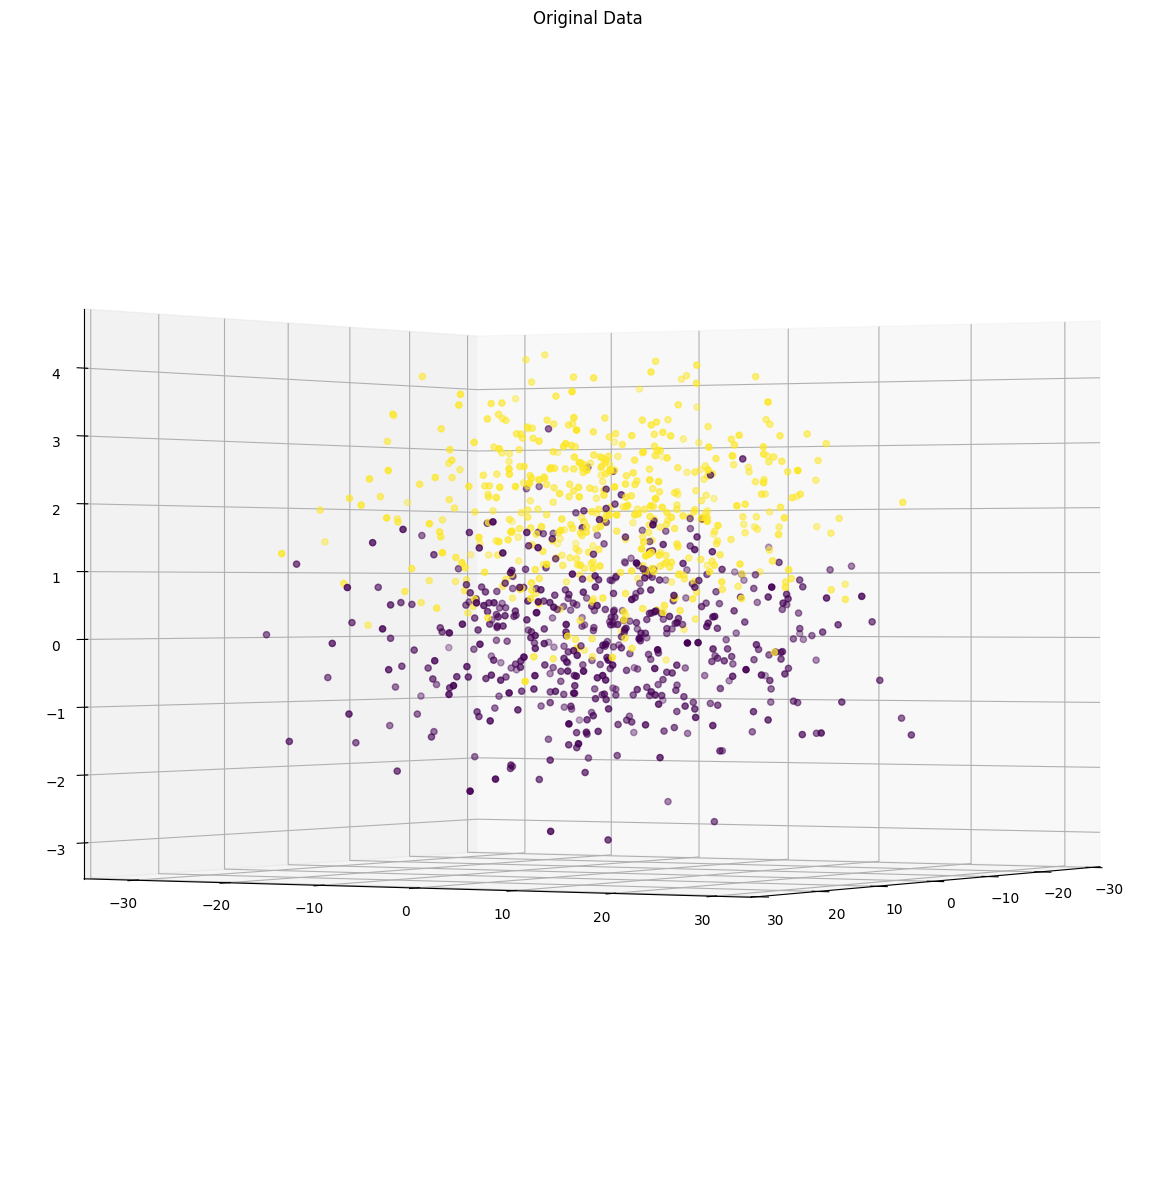

In [ ]:
# @SHOW
# Generate synthetic data
np.random.seed(0)
n_points = 500

# Class 0
x0 = np.random.normal(loc=0, scale=10, size=n_points)
y0 = np.random.normal(loc=0, scale=10, size=n_points)
z0 = np.random.normal(loc=0, scale=1, size=n_points)

# Class 1
x1 = np.random.normal(loc=0, scale=10, size=n_points)
y1 = np.random.normal(loc=0, scale=10, size=n_points)
z1 = np.random.normal(loc=2, scale=1, size=n_points)

X = np.vstack((np.hstack((x0, x1)), np.hstack((y0, y1)), np.hstack((z0, z1)))).T
y = np.hstack((np.zeros(n_points), np.ones(n_points)))



# Train KNN on original data
knn = KNeighborsClassifier()
knn.fit(X, y)
y_pred = knn.predict(X)
print(f"Original Data Accuracy: {accuracy_score(y, y_pred)}")

# Create a new figure
fig = plt.figure(figsize=(15,15))

# Add 3D subplot
# The format is (rows, columns, plot_number)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=30)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
ax.set_title('Original Data')

plt.show()


In [ ]:
# @SHOW
# Set up train and test, and examine predictions without dimensionality reduction

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Original Data Accuracy: {accuracy_score(y_test, y_pred)}")

Original Data Accuracy: 0.725


1. Try with PCA

In [ ]:
# Your code here


In [ ]:
# Your code here


2. Try with UMAP.

In [ ]:
# Your code here


In [ ]:
# Your code here


Explain your results in the cell below.  Which works better?  Why?

*Enter your answer in this cell*